In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [192]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [5]:
#### Make measurement

In [6]:
import sys
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [7]:
from vanilla_measure_all import measure_vanilla
from kuaizi.measure import initialize_meas_cat, makeMeasurement
from tqdm import trange

In [193]:
lsbg_cat = vstack([Table.read('./Catalog/tiny_sample/tiny_sample_cutout_cat_tiny_sample.fits'), 
                   Table.read('./Catalog/tiny_sample/tiny_sample_cutout_cat_tiny_sample_2.fits')])
lsbg_cat.sort('viz-id')

In [195]:
lsbg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/greco16_tiny.txt', format='ascii')

In [196]:
meas_cat = initialize_meas_cat(lsbg_cat)

In [197]:
for i in trange(len(lsbg_cat)):
    measure_vanilla(i, lsbg_cat, 
                    meas_cat, 
                    '/tigress/jiaxuanl/Data/HSC/LSBG/Model/tiny_sample/', 
                    'tiny', 
                    method='vanilla', 
                    makesegmap=False)

 15%|█▌        | 25/162 [01:37<11:50,  5.19s/it]

IMCOMPLETE FILE FOR tiny-25 [Errno 2] No such file or directory: '/tigress/jiaxuanl/Data/HSC/LSBG/Model/tiny_sample/tiny-25-trained-model-vanilla.df'
MEASUREMENT ERROR FOR tiny-25 local variable 'blend' referenced before assignment


100%|██████████| 162/162 [10:03<00:00,  3.73s/it]


In [198]:
meas_cat.write('./Catalog/tiny_sample/tiny_measure_vanilla_nosegmap_all.fits', overwrite=True)

In [76]:
### Galsim sersic_half_light_radius = rhalf_circularized, after PSF deconvolution

In [64]:
lsbg_cat['sersic_rhalf_circ'][:5]

3.6462432660295585
2.423395579884298
3.3679460527719245
1.6348685118389001
1.6231889713703556


In [134]:
lsbg_cat['mags'][idx] + 2.5 * np.log10(2 * np.pi * lsbg_cat['sersic_rhalf_circ'][idx]**2)

array([28.53713066, 28.11778963, 27.88365256, 27.84634048])

In [113]:
meas_cat['SB_eff_avg'][idx]

array([24.08226967, 23.60842514, 23.36719322, 23.29233932])

In [77]:
meas_cat['sersic_n'][idx], lsbg_cat['sersic_n'][idx]

(0.8334087356695213, 0.7603172423821216)

In [81]:
meas_cat['sersic_rhalf'][idx] * 0.168 * np.sqrt(meas_cat['sersic_ell'])[idx], lsbg_cat['sersic_rhalf_circ'][idx]

(3.0053796597677898, 3.3679460527719245)

In [83]:
meas_cat['sersic_amp'][idx]

0.0547654486943269

In [135]:
lsbg_cat['mags'][idx], meas_cat['mag'][idx]

(array([22.84884427, 22.42950324, 22.19536617, 22.15805409]),
 array([nan, nan, nan, nan]))

In [97]:
from kuaizi.measure import cal_mu0, cal_mue, fn

In [116]:
cal_mue(lsbg_cat['sersic_n'][idx], 
        lsbg_cat['sersic_rhalf_circ'][idx], 
        lsbg_cat['mags'][idx][0]) - 2.5 * np.log10(fn(lsbg_cat['sersic_n'][idx]))

23.36955565383528

In [115]:
meas_cat['SB_eff_avg'][idx]

array([24.08226967, 23.60842514, 23.36719322, 23.29233932])

In [1]:
ind = 157

In [372]:
with open(f'/tigress/jiaxuanl/Data/HSC/LSBG/Model/tiny_sample/tiny-{ind}-trained-model-vanilla.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

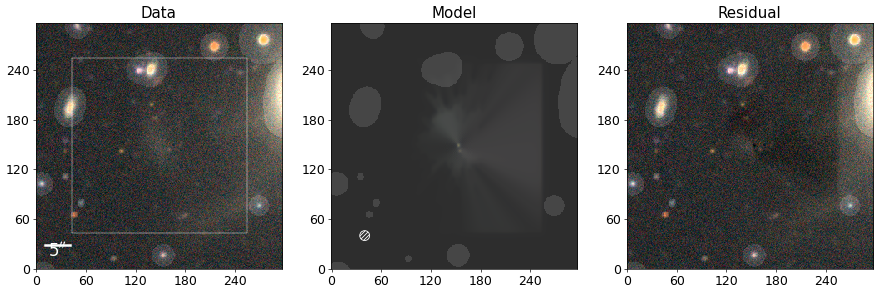

In [373]:
kz.display.display_scarlet_model(
    blend,
    show_ind=[0],
    zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False)

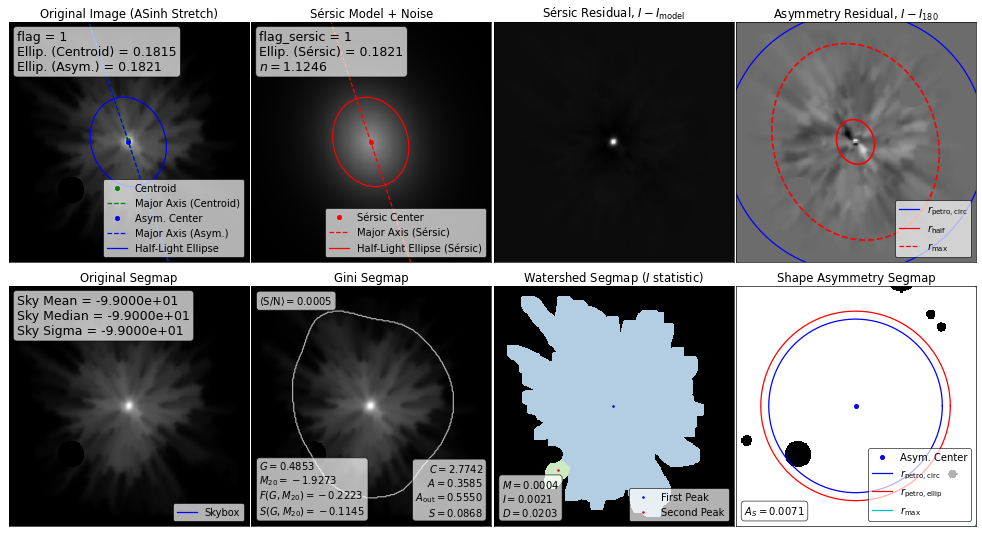

In [370]:
measurement, _ = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=None, #mask.astype(bool),
                                 makesegmap=False, sigma=1,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [364]:
measurement['sersic_rhalf'] * np.sqrt(1 - measurement['sersic_ellip']) * 0.168, measurement['rhalf_circularized'] * 0.168

(6.761049310593993, 6.761049310593995)

In [365]:
lsbg_cat['sersic_rhalf_circ'][ind]

9.632980847069094

In [356]:
-2.5 * np.log10(measurement['flux_circ']) + 27.0, lsbg_cat[ind]['mags']

(array([22.53637 , 22.031425, 21.799068, 21.622334], dtype=float32),
 array([22.26, 21.64, 21.34]))

In [366]:
measurement['SB_eff_avg'][2], lsbg_cat[ind]['iSB'] + 2.5 * np.log10(fn(lsbg_cat[ind]['n']))

(26.42857, 26.05192279734704)

In [252]:
-2.5 * np.log10(measurement['flux_circ']) + 27.0 + 2.5 * np.log10(2 * np.pi * (measurement['sersic_rhalf'] * np.sqrt(1 - measurement['sersic_ellip']) * 0.168)**2)

array([25.060417, 24.524616, 24.203842, 23.874573], dtype=float32)

### Comparison with groud truth

In [37]:
from kuaizi.measure import fn

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
lsbg_cat = vstack([Table.read('./Catalog/tiny_sample/tiny_sample_cutout_cat_tiny_sample.fits'), 
                   Table.read('./Catalog/tiny_sample/tiny_sample_cutout_cat_tiny_sample_2.fits')])
meas_cat = Table.read('./Catalog/tiny_sample/tiny_measure_vanilla_nosegmap_all.fits')

meas_cat['mag_circ'] = -2.5 * np.log10(meas_cat['flux_circ']) + 27.0
lsbg_cat['SB_eff_avg_i'] = lsbg_cat['iSB'] + 2.5 * np.log10(fn(lsbg_cat['n']))
gmag = (lsbg_cat['imag'] + lsbg_cat['g-i']).data
imag = lsbg_cat['imag']
rmag = gmag - lsbg_cat['g-r'].data
lsbg_cat['mags'] = np.vstack([gmag, rmag, imag]).T

lsbg_cat['sersic_rhalf_circ'] = lsbg_cat['Reff'] * np.sqrt(1 - lsbg_cat['Ell'])

NameError: name 'vstack' is not defined

Text(0.5, 0.98, 'Small R_e objects from Greco+18 (as truth)')

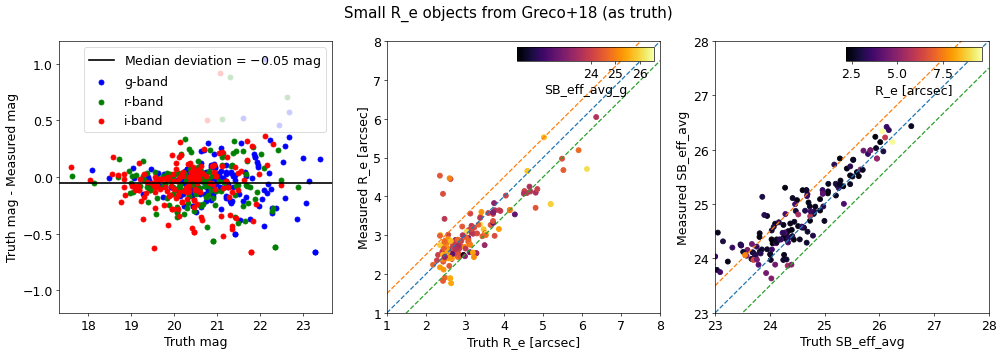

In [376]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

plt.sca(axes[0])
plt.scatter(lsbg_cat['mags'][:, 0], 
            lsbg_cat['mags'][:, 0] - meas_cat['mag_circ'][:, 0], color='b', label='g-band')
plt.scatter(lsbg_cat['mags'][:, 1], 
            lsbg_cat['mags'][:, 1] - meas_cat['mag_circ'][:, 1], color='g', label='r-band')
plt.scatter(lsbg_cat['mags'][:, 2], 
            lsbg_cat['mags'][:, 2] - meas_cat['mag_circ'][:, 2], color='r', label='i-band')
#plt.scatter(lsbg_cat['mags'][flag][:, 0], lsbg_cat['mags'][flag][:, 0] - meas_cat[flag]['mag_circ'][:, 0])
med_dev = np.nanmedian([np.nanmedian(lsbg_cat['mags'][:, 0] - meas_cat['mag_circ'][:, 0]),
                        np.nanmedian(lsbg_cat['mags'][:, 1] - meas_cat['mag_circ'][:, 1]),
                        np.nanmedian(lsbg_cat['mags'][:, 2] - meas_cat['mag_circ'][:, 2])])
plt.axhline(med_dev, lw=2, c='k', label=f'Median deviation = ${med_dev:.2f}$ mag')
plt.xlabel('Truth mag')
plt.ylabel('Truth mag - Measured mag')
plt.legend()
plt.ylim(-1.2, 1.2)

plt.sca(axes[1])
#axes[0, 1].set_aspect('equal')
plt.scatter(lsbg_cat['sersic_rhalf_circ'], 
            meas_cat['rhalf_circularized'] * 0.168, 
            c=lsbg_cat['SB_eff_avg_i'])

x = np.linspace(1, 8, 10)
plt.plot(x, x, '--')
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')
plt.xlabel('Truth R_e [arcsec]')
plt.ylabel('Measured R_e [arcsec]')
plt.xlim(1, 8)
plt.ylim(1, 8)
cbaxes = inset_axes(plt.gca(), width="50%", height="5%") 
plt.colorbar(cax=cbaxes, ticks=[24, 25, 26, 27], orientation='horizontal', label='SB_eff_avg_g')
# plt.sca(axes[1])
# dev = (lsbg_cat['sersic_rhalf_circ'] - meas_cat['rhalf_circularized'] * 0.168) / (lsbg_cat['sersic_rhalf_circ'])
# flag = np.abs(dev) > 0.15
# plt.scatter(lsbg_cat[flag]['sersic_rhalf_circ'], 
#             meas_cat[flag]['rhalf_circularized'] * 0.168)

plt.sca(axes[2])
plt.scatter(lsbg_cat['SB_eff_avg_i'], 
            meas_cat['SB_eff_avg'][:, 2], 
            c=lsbg_cat['sersic_rhalf_circ'])
x = np.linspace(23, 28, 10)
plt.plot(x, x, '--')
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')
plt.xlabel('Truth SB_eff_avg')
plt.ylabel('Measured SB_eff_avg')
plt.xlim(23, 28)
plt.ylim(23, 28)
cbaxes = inset_axes(plt.gca(), width="50%", height="5%") 
plt.colorbar(cax=cbaxes, orientation='horizontal', label='R_e [arcsec]')

plt.suptitle('Small R_e objects from Greco+18 (as truth)')

In [208]:
dev = (lsbg_cat['sersic_rhalf_circ'] - meas_cat['rhalf_circularized'] * 0.168) / (lsbg_cat['sersic_rhalf_circ'])
flag = np.abs(dev) > 0.2

In [211]:
lsbg_cat[flag]['viz-id'].data

array([  5,  14,  15,  23,  38,  49,  50,  64,  65,  70,  78,  82,  84,
        92,  98, 108, 109, 111, 112, 113, 117, 121, 123, 128, 133, 157])

In [377]:
from PIL import Image

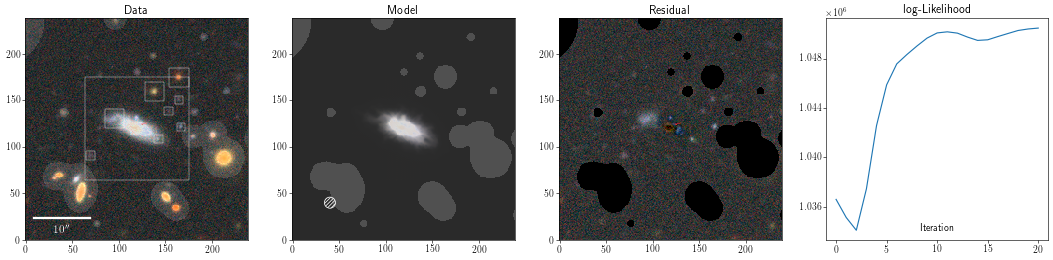

In [391]:
Image.open('/tigress/jiaxuanl/Data/HSC/LSBG/Figure/nsa_z002_004/nsa-3795-zoomin-vanilla.png')